
# EDA and preparing the data 

This notebook includes some important data exploration, groupings and breakdowns of different features, relvant visualizations and some statistics. Furthermore it builds the dataframe that is used in the model notebook(s) which includes the Naive Bayes calculation.

** ** 
### Includes:
 1. Most Common Diagnoses Fatal v. Non Fatal
 1. * Using Naive Bayes to find diseases that are good features *
  
    \\[\frac{P( Death  |  icd9=x) }{P( Survival | icd9 x)} \\]
    
 1. Combination of Patients and Admissions table
 1. First Model: Gender and Age Logistic Regression
 1. Create DataFrame with icd9- as features
 1. (optional) if you wanna look at ethnicity
 
#### terms in data tables 

* hadm_id    = hospital admission id (one patient could map to several) 
* subject_id = personal id (unique to patient)
* seq_num    = sequential number of diagnosis ( 1 being most serious/reason for coming in)  
** **

   ## outline

1. **Part 1**:  Answering a few basic stats
1. **Part 2**: Visualization,  Histograms
1. **Part 3**: Most common icd9 codes fatal/survival; Data Frames
    1. **Part 3b**:  Table of most common Diagnoses (long-title) ; Fatal NON-Fatal
    1. **Part 3c**:  Create a pre-bayes data for modelling
    1. ** Part 3d**: CREATE an external test-set 
1. **Part 4**: Naive bayes;  find good features from Diagnoses using Likelihood model
    1. **Part 4a **: Calculate Fatality
1. **Part 5 **:  DF with icd9-codes
    1.**Part 5a ** : pivot table 
1. Part 7 (?) First Logistic Model: Gender, Age, Admission type
** **

 # Instructions for creating Modeling table: 

How to create a pivot table ready for modeling, ie. how to encode Diagnosis Codes 
** Logistic regression takes in only numeric values, so diagnosis codes have to be encoded in [0,1] format **


1. **df_model** should be a DF containing: 
    1. 	hadm_id	subject_id_x	expire_flag_x	icd9_code	gender	admission_type	diagnosis	age
    1. ** every Row of df_model ** contains a unique icd9-code, per hospital stay
    1. that's why it has so many rows
    1. ** num Rows** = hospital-stays x icd9-code 
1. create a column of =1 in **df_model**
    1. for the merge, to pass as values
1. pivot **tmp**
        1. tmp = pd.pivot_table(df_model, values='d', index=['hadm_id','subject_id_x'], columns=['icd9_code'])
1. ** reset index level ** at tmp
        1. tmp.reset_index(col_level=0, inplace = True)
1. Merge **df_tmp** (DF with gender, admission_type, diagnosis, age, expire_flag, AND hamd_id, subject_id,) and ** tmp ** (pivot DF with hamd_id, subject_id, AND encoded icd9 codes) 
    1. on hamd_id (HOSPITAL stay)
    1. how = left
1. drop the extra columns 
        1. .drop('subject_id_x_y', axis=1, inplace=True)
    



In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
####import all the previously assembled data 

# general dataframe with more info: time, gender, language etc
data = pd.read_csv("mimic_data/admit_1.csv")
### dataframe containing all diagnosis codes for hospital visits tagged: expired/fatal 
df_expired = pd.read_csv("mimic_data/icd9_expire1.csv")

# dataframe containing all diagnosis codes for hospital visits tagged: survived
df_alive = pd.read_csv("mimic_data/icd9_expire0.csv")

# dataframe containing all diagnoses (short & long) for all hospital visits
diagnoses = pd.read_csv("mimic_data/diagnoses.csv")

# DICTIONARY of DIAGNOSES (procedures);  only 3882 rows 
procedures = pd.read_csv("mimic_data/procedures.csv")

#### Data files key 
* **df_alive** - every single icd9 code for every single hospital visit  -- survived
* **df_expired** - every single icd9 code for every single hospital visit -- fatal

** Data ** contains gender, dob, (religion, ethnicity etc. other events)
    - contains:
        - number of unique hospital visits
        - expire flag
        - gender
    - does not contain
        - all icd9-codes per visit and seq_number (order of code importance)  
** diagnoses **
   - icd9- codes and seq_num for all visits
   
##### SEQ_NUM is from DIAGNOSES
- SEQ_NUM provides the order in which the ICD diagnoses relate to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment.
- this is relevant for Part 3: Most common Diagnosis
    - and Naive Bayes

In [5]:
data[:2]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data
0,30,M,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1
1,8402,M,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1


In [6]:
df_expired[:2]

,hadm_id,subject_id,expire_flag,icd9_code
0,121205,91,1,20008
1,121205,91,1,2765


In [7]:
df_alive[:3]

,hadm_id,subject_id,expire_flag,icd9_code
0,163353,2,0,V3001
1,163353,2,0,V053
2,163353,2,0,V290


In [8]:
diagnoses[:2]

,row_id,subject_id,hadm_id,seq_num,icd9_code,row_id.1,icd9_code.1,short_title,long_title
0,243,34,115799,8.0,E8790,13429.0,E8790,Abn react-cardiac cath,Cardiac catheterization as the cause of abnorm...
1,244,34,144319,1.0,42789,4471.0,42789,Cardiac dysrhythmias NEC,Other specified cardiac dysrhythmias


In [9]:
procedures[:3]

,row_id,icd9_code,short_title,long_title
0,86,64,Perc ins extracran stent,Percutaneous insertion of other extracranial a...
1,87,65,Perc ins intracran stent,Percutaneous insertion of intracranial vascula...
2,88,66,PTCA,Percutaneous transluminal coronary angioplasty...


In [11]:
print (" all hospital visits in data \t", len(data['hadm_id'].unique()))
print ( " all hospital visits in diagnoses \t",len(diagnoses['hadm_id'].unique()))
print ( " \t codes \t")
print ("all codes in procedures " ,len(procedures['icd9_code'].unique()))
print ("all codes in diagnoses \t" ,len(diagnoses['icd9_code'].unique()))
print ("all codes in df_alive \t" ,len(df_alive['icd9_code'].unique()))
print ("all codes in df_expired " ,len(df_expired['icd9_code'].unique()))

 all hospital visits in data 	 58976
 all hospital visits in diagnoses 	 58976
 	 codes 	
all codes in procedures  3809
all codes in diagnoses 	 6985
all codes in df_alive 	 6423
all codes in df_expired  4824


# Create a table of diagnosis key:
to be used in the model notebook

In [12]:
colz = ['icd9_code', 'short_title', 'long_title']

diagnoses_key = diagnoses.groupby('icd9_code').first().reset_index()

diagnoses_key=diagnoses_key[colz]

#diagnoses_key.to_csv('diagnoses_key.csv', index=None)

In [13]:
#diagnoses_key

In [14]:
print (len(diagnoses_key))
diagnoses_key[diagnoses_key['icd9_code']== 'V4578']

6984


,icd9_code,short_title,long_title
6775,V4578,Acquired absence of eye,"Acquired absence of organ, eye"


In [14]:
## diagnoses.groupby('hadm_id').count() # returns DF with number codes per visit
## diagnoses.groupby('')

 # Part 1:  Answering a few basic stats

#### regarding data frames

the goal is to obtain a dataframe of admissions with both expired flag [ survived/expired ] and also obtain an idea of what are the most common icd9 codes

+ ** admit_1.csv ** used to get # admissions + expire_flag
+ ** icd9_expire.csv ** to find the most common icd9 codes

** ** ** 
     # How many unique codes for fatal cases?  4824
     #How many unique codes for survived cases? 6423
    **

In [15]:
# How many unique codes for fatal cases? 
len(df_expired.icd9_code.unique())

4824

In [16]:
#How many unique codes for survived cases? 
len(df_alive.icd9_code.unique())

6423

In [17]:
# info on the data types in diagnoses
diagnoses.info()
# How many unique codes present in diagnoses? 
len(diagnoses.icd9_code.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 9 columns):
row_id         651047 non-null int64
subject_id     651047 non-null int64
hadm_id        651047 non-null int64
seq_num        651000 non-null float64
icd9_code      651000 non-null object
row_id.1       634709 non-null float64
icd9_code.1    634709 non-null object
short_title    634709 non-null object
long_title     634709 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 44.7+ MB


6985

In [18]:
df_expired.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719641 entries, 0 to 719640
Data columns (total 4 columns):
hadm_id        719641 non-null int64
subject_id     719641 non-null int64
expire_flag    719641 non-null int64
icd9_code      719552 non-null object
dtypes: int64(3), object(1)
memory usage: 22.0+ MB


##### adjust age 
due to anonymization lots of ages are set at much smaller than 0; these are actually really old people, set all these ages to 90

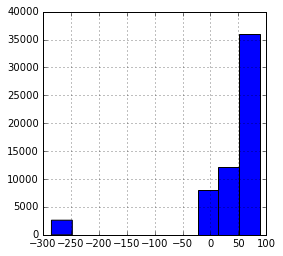

In [19]:
######### ADD AGE 
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(data.admittime) - pd.to_datetime(data.dob )
              ).astype('<m8[Y]')

data['age'].hist(figsize=(4,4));

#### SET ALL SMALLER THAN 0 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

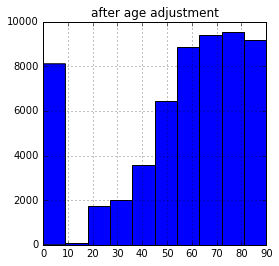

In [20]:
data['age'].hist(figsize=(4,4))
plt.title('after age adjustment');

In [21]:
# dob year
data['year']=  pd.DatetimeIndex(data['dob']).year

In [22]:
#pd.to_datetime(data.dob)
#.apply(lambda x: x.strftime('%B-%Y'))  #.astype('<m8[Y]')

In [23]:
data.columns

Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data', u'age', u'year'],
      dtype='object')

# Part2: Visualization,  Histograms 

breakdown data by age, gender, and the expire flag and look at what the distribution looks like 

    ** Number of survived/fatal cases by age
    ** Number of survived/fatal cases by gender
        ** CHECK MORTALITY DISTRIBUTION BY % (GENDER) 

In [24]:
#data.loc[(data['expire_flag']==0), 'age']
data[data['age']<10.0][:3]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data,age,year
55,16414,F,2180-02-21 00:00:00,NaN,0,20044,16414,142208,2180-03-03 12:34:00,2180-03-05 12:45:00,...,NaN,ASIAN,NaN,NaN,HYPERBILIRUBIMIA,0,1,1,0.0,2180
65,15593,F,2143-01-27 00:00:00,NaN,0,19041,15593,150263,2143-02-01 17:39:00,2143-02-04 13:16:00,...,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA,0,1,1,0.0,2143
153,14258,M,2136-02-03 00:00:00,NaN,0,17464,14258,109672,2136-02-03 20:37:00,2136-02-09 18:57:00,...,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,PREMATURITY,0,1,1,0.0,2136


In [25]:
## Create series for adolescent and adult patients (no children under 10)
fatal_series = data.loc[(data['expire_flag']==1),'age' ]
fatal_series = fatal_series[fatal_series>10]

survive_series = data.loc[(data['expire_flag']==0),'age' ]
survive_series = survive_series[survive_series>10]

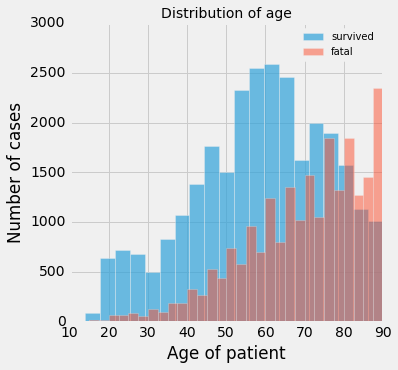

In [26]:
## choose and savewhichever style works better
#plt.style.use('bmh')
plt.style.use('fivethirtyeight')
plt.figure(figsize = (5,5))
plt.hist(survive_series, bins=20, alpha=0.7, label='survived') #color='purple',
plt.hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')

plt.title('Distribution of age', fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('Age of patient')
plt.ylabel('Number of cases');
#plt.savefig('Age_dist')

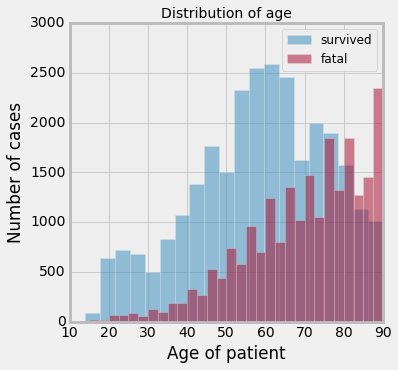

In [27]:
plt.style.use('bmh')
plt.figure(figsize = (5,5))
plt.hist(survive_series, bins=20, alpha=0.5, label='survived') #color='purple',
plt.hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')
plt.title('Distribution of age', fontsize=14)
plt.legend(fontsize=12); plt.xlabel('Age of patient'); plt.ylabel('Number of cases');
#plt.savefig('Age_dist')

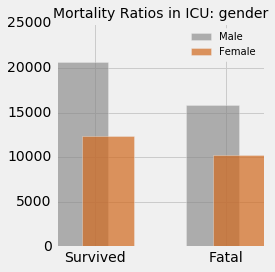

In [28]:
# 0-M, 1-F
plt.style.use('fivethirtyeight')
g_0 = data.loc[(data['expire_flag']==0),'gender' ].value_counts() # survived M/F
g_1 = data.loc[(data['expire_flag']==1),'gender' ].value_counts() # fatal M/F

plt.figure(figsize = (4,4))
x = np.arange(0,2)
wid = 0.4

plt.bar(x+0.2, g_0, wid, alpha=0.6, label='Male',color='grey',)#  'male'
plt.bar(x+ 0.4, g_1, wid,alpha=0.7, label = 'Female', color='chocolate') # 'female'
plt.xticks(x+0.5, ['Survived', 'Fatal'])
plt.title('Mortality Ratios in ICU: gender', fontsize=14)
plt.tight_layout()  #plt.savefig('gender')
plt.legend(fontsize=10);

more males than females were admitted; Plot expire_flag (0:1) as a **percentage** of all admitted broken down by gender

In [29]:
pd.DataFrame(data.loc[(data['gender']=='M'),'expire_flag' ].value_counts() )

,expire_flag
0,20600
1,12350


In [30]:
#m_0 = m_0.rename(columns={'expire_flag':'count'}).reset_index()
#m_0.rename(columns={'index':'expire_flag'},inplace=True)

In [31]:
m_0 = pd.DataFrame(data.loc[(data['gender']=='M'),'expire_flag' ].value_counts()) # survived M/F
f_0 = pd.DataFrame(data.loc[(data['gender']=='F'),'expire_flag' ].value_counts()) # fatal M/F

m_0['gender'] = 'M'
f_0['gender'] = 'F'
m_0['expire_percent'] = (m_0['expire_flag'].div(m_0.expire_flag.sum())*100).apply(lambda x: round(x,2))
f_0['expire_percent'] = (f_0['expire_flag'].div(f_0.expire_flag.sum())*100).apply(lambda x: round(x,2))
# expire flag and count columns
m_0 = m_0.rename(columns={'expire_flag':'count'}).reset_index()
m_0.rename(columns={'index':'expire_flag'},inplace=True)
f_0 = f_0.rename(columns={'expire_flag':'count'}).reset_index()
f_0.rename(columns={'index':'expire_flag'},inplace=True)

gender_frames = pd.concat([m_0,f_0])

/Users/billierolih/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [32]:
expire = ["survived", "fatal"]
n_g = ['0','1']
gender_frames['expire_flag'] = gender_frames['expire_flag'].astype(str)
gender_frames.expire_flag.replace(n_g,expire, inplace=True)

In [33]:
gender_frames

,expire_flag,count,gender,expire_percent
0,survived,20600,M,62.52
1,fatal,12350,M,37.48
0,survived,15790,F,60.67
1,fatal,10236,F,39.33


#### Part 2b. :  Hospital admits more men, what is the survival rate by gender? 

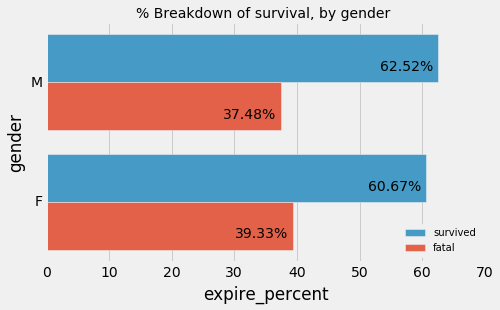

In [34]:
plt.figure(figsize=(7,4))
ax = sns.barplot(x="expire_percent", y="gender", hue="expire_flag",data=gender_frames)
ax.legend(fontsize=10, loc=4)
ax.set_title("% Breakdown of survival, by gender ",fontsize = 14 )
# ax.text (gender_frames.expire_percent)
for p in ax.patches:
    width = p.get_width()
    ax.text(width - 5, #+p.get_height()/2.,
            p.get_y()+p.get_height()/2 +0.1,
            '{:1.2f}%'.format(width),#width/total),
            ha="center");
#show()
#plt.savefig('survival_by_gender');

In [35]:
ma = gender_frames[gender_frames.gender=='M']['count'].sum() 
fa =gender_frames[gender_frames.gender=='F']['count'].sum() 
print(" Number of male admissions ", ma)
print(" Number of female admissions ",fa )
print (" difference", ma - fa)
print ("% of total", round((ma-fa)/(ma+fa)*100, 2))

 Number of male admissions  32950
 Number of female admissions  26026
 difference 6924
% of total 11.74


The hospital admits more men (almost 7000, about 12% more) but observes 2% higher fatalities in women.

Is this statistically significant? 

### I think we wanna do a Chi-square test here** .

**T-test** 
A t-test is a statistical test that can help us estimate whether the difference in a numerical measure between two groups is reliable. 

###### Chi-Test Null hypothesis
    there is no difference in fatal cases in the categorical value "gender" i.e. that the observed and expected frequencies are the same.

In [36]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare
# interpret test-statistic
prob = 0.95

In [37]:
gender_frames

,expire_flag,count,gender,expire_percent
0,survived,20600,M,62.52
1,fatal,12350,M,37.48
0,survived,15790,F,60.67
1,fatal,10236,F,39.33


To do a one-way chi square test on expire_flag/ Gender?? Do it on a subset of data, which includes gender, and expire flag

In [38]:
data.loc[:,['gender', 'expire_flag']][:3]

,gender,expire_flag
0,M,0
1,M,0
2,M,1


In [39]:
data.loc[:,'gender'].value_counts()

M    32950
F    26026
Name: gender, dtype: int64

In [40]:
# first let's do a one-way chi-squared test for M/F in gender_frame
#scipy.stats.
chisquare(data.loc[:,'gender'].value_counts())

Power_divergenceResult(statistic=812.9031470428649, pvalue=8.447194609871837e-179)

##### Interpretation
The larger the statistic (the chi-squared statistic) the more difference there is from a uniform distribution. We can be sure that the genders are not all equally likely to be admitted to the hosptial 

Now let's find out: is there a relationship between gender and fatality? 

In [41]:
contingency_table=pd.crosstab(data['gender'],data['expire_flag'])
contingency_table

expire_flag,0,1
gender,,
F,15790,10236
M,20600,12350


In [42]:
chi2_contingency(contingency_table)

(20.956179870969887,
 4.699095218712981e-06,
 1,
 array([[16058.83986706,  9967.16013294],
        [20331.16013294, 12618.83986706]]))

1. Chi-squared value
1. p-value, which is very very small here; it seems unlikely there is no connection between gender and the expire flag 

we ran two different tests with small p value, it seems unlikely this is random variability, and gender seems a good feature to keep 

In [43]:
# ############ Admission_type into categorical 
cols_a = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums_a = [0, 1, 2, 3 ]
print(data.admission_type.unique())
print(cols_a)

data.admission_type.replace(cols_a, nums_a, inplace=True)
adm_alive = data.loc[(data['expire_flag']==0),'admission_type' ]
adm_fatal = data.loc[(data['expire_flag']==1),'admission_type' ]

['URGENT' 'NEWBORN' 'EMERGENCY' 'ELECTIVE']
['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']


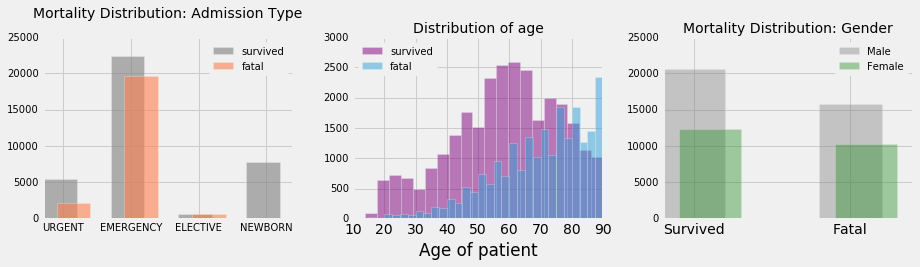

In [44]:
"""
   combined plot 
"""
fig, ax = plt.subplots(1,3, figsize = (13,4))

x = np.arange(0,4)
wid = 0.5
ax[0].yaxis.set_tick_params(labelsize=10)
ax[1].yaxis.set_tick_params(labelsize=10)
ax[2].yaxis.set_tick_params(labelsize=10)

ax[0].bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), 
          wid, alpha=0.6,color='grey', label='survived')
#adm_alive.value_counts().sort_index(ascending=False).plot.barh()
ax[0].set_xticks(x+0.5)
ax[0].set_xticklabels(['URGENT', 'EMERGENCY', 'ELECTIVE','NEWBORN'],fontsize=10)
#ax[0].set_yticklabels(fontsize=10)
ax[0].bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), 
          wid,alpha=0.6, color='coral', label='fatal')
ax[0].legend(fontsize=10)
ax[0].set_title('Mortality Distribution: Admission Type', fontsize=14, y=1.08)
#ax[0].set_yticks([],size=10)
#reduce s9ze of y-ticks

ax[1].hist(survive_series, bins=20,color='purple', alpha=0.5, label='survived')
ax[1].hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')

ax[1].set_title('Distribution of age', fontsize=14)
ax[1].legend(fontsize=10, loc=2)
ax[1].set_xlabel('Age of patient')
#ax[1].set_ylabel('Number of cases')

x1 = np.arange(0,2)
wid1 = 0.4

ax[2].bar(x1+0.2, g_0, wid1, alpha=0.4,color='grey', label='Male')
ax[2].bar(x1+ 0.3, g_1, wid1,alpha=0.4, label = 'Female', color='forestgreen')
ax[2].set_xticks(x1+0.4)
ax[2].set_xticklabels(['Survived', 'Fatal'])
ax[2].set_title('Mortality Distribution: Gender', fontsize=14)
ax[2].legend(fontsize=10);

plt.tight_layout() 
#plt.savefig('ALL_Distributions')

#plt.savefig('Age_dist')

[<matplotlib.text.Text at 0x1121afed0>, <matplotlib.text.Text at 0x1144f8b50>]

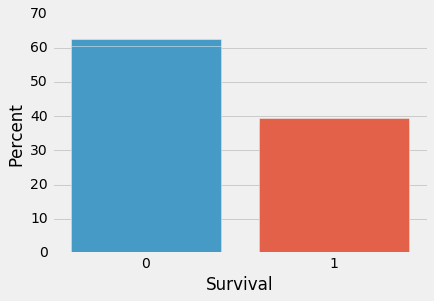

In [45]:
ax = sns.barplot(x=m_0.index, y='expire_percent', data=m_0)
ax = sns.barplot(x=f_0.index, y='expire_percent', data=f_0)
#             estimator= lambda x: sum(x==0)*100.0/len(x) )
ax.set(ylabel="Percent", xlabel='Survival')

In [46]:
adm_fatal.value_counts().sort_index(ascending=False)

3     2186
2    19650
1      685
0       65
Name: admission_type, dtype: int64

### seperate plot for type of Admission 

<Container object of 4 artists>

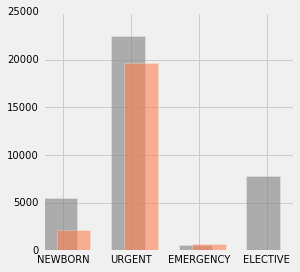

In [47]:
plt.figure(figsize = (4,4))
x = np.arange(0,4)
wid = 0.5

plt.bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), wid, alpha=0.6,
        color='grey', label='survived')
plt.xticks(x+0.5, cols_a,fontsize=10)
plt.yticks(fontsize=10)

plt.bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), wid,alpha=0.6,  
        color='coral', label='fatal')

In [48]:
adm_alive.value_counts().sort_index(ascending=False)

3     5520
2    22421
1      651
0     7798
Name: admission_type, dtype: int64

In [49]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
data.gender.replace(gen, n_g, inplace=True)

### Sepearate distribution by age (with rugplot)

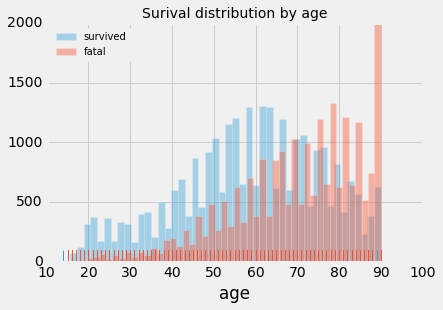

In [50]:
## interrupted, the rugplot takes a while
x_0 =data.loc[(data['expire_flag']==0),'age' ]
x_1 = data.loc[(data['expire_flag']==1),'age' ]

sns.distplot(x_0[x_0>10], label = 'survived', kde=False, rug=True)
sns.distplot(x_1[x_1>10], label = 'fatal', kde=False, rug=True)

# for distplots remembering order is cruical when writing legends
plt.legend(['survived', 'fatal'],fontsize=10,loc=2)
plt.title('Surival distribution by age',fontsize = 14);

#plt.savefig('Dist_by_age')

In [51]:
# more men admitted to ICU
print(g_0)
print(g_1)
print ("men " ,20600 +  12350)
print ("women " , 15790 +  10236)

M    20600
F    15790
Name: gender, dtype: int64
M    12350
F    10236
Name: gender, dtype: int64
men  32950
women  26026


## Part 3: Most common icd9 codes fatal/survival; Data Frames

### Start with Fatal Cases 

In [11]:
"""
    ONLY fatal cases 
"""
df_expired[:3]

,hadm_id,subject_id,expire_flag,icd9_code
0,121205,91,1,20008
1,121205,91,1,2765
2,121205,91,1,5559


In [12]:
# sorted by: the most common icd9_codes
most_common_icd9 = (df_expired.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

## how many expired? 
most_common_icd9.rename(columns={'expire_flag':'num_expire_flags'}, inplace=True)

In [13]:
## 50 most common codes; but what are they? 
most_common_icd9_smaller = most_common_icd9.iloc[:50,:]
#[['icd9_code']][:20]

    most_common_icd9 - count expire_flag
    most_common_icd9_smaller - 50 most common

In [14]:
len(most_common_icd9_smaller)
most_common_icd9_smaller[:3]
### remove hadm_id and subject_id (these are aggregates anyway)
most_common_icd9_smaller.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)

/Users/billierolih/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
most_common_icd9_smaller[:3]

,icd9_code,num_expire_flags
1627,4280,20339
1495,4019,16894
1616,42731,15895


### Join common icd9_codes to DIAGNOSES
-- find what the 50 most common DIAGNOSES
-- do an inner join, keep only rows preset
    - merge left on id9 code ( smaller, larger)

#### SEQ_NUM is from DIAGNOSES
-- SEQ_NUM provides the order in which the ICD diagnoses relate to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment.



In [15]:
# diagnoses.drop(['icd9_code.1', 'row_id.1'], axis=1, inplace=True)
# diagnoses.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
diagnoses.drop(['seq_num', 'row_id'], axis=1, inplace=True)

In [16]:
diagnoses[:2]

,subject_id,hadm_id,icd9_code,row_id.1,icd9_code.1,short_title,long_title
0,34,115799,E8790,13429.0,E8790,Abn react-cardiac cath,Cardiac catheterization as the cause of abnorm...
1,34,144319,42789,4471.0,42789,Cardiac dysrhythmias NEC,Other specified cardiac dysrhythmias


In [22]:
merged_MOSTCOMMONicd9 = pd.merge(most_common_icd9_smaller, diagnoses, how='left',on='icd9_code')

In [23]:
"""
    merged DataFrame: for fatal expire_flag=1
"""
merged_MOSTCOMMONicd9[:2]

,icd9_code,num_expire_flags,subject_id,hadm_id,row_id.1,icd9_code.1,short_title,long_title
0,4280,20339,34,144319,4473.0,4280,CHF NOS,"Congestive heart failure, unspecified"
1,4280,20339,37,188670,4473.0,4280,CHF NOS,"Congestive heart failure, unspecified"


## Part 3b:  Table of most common Diagnoses (long-title) ; Fatal + Survived

In [24]:
""" 
    tmp_fatal - need a DF of (unique) codes, sorted by NUM most expired flags
"""
tmp_fatal = (merged_MOSTCOMMONicd9.
groupby('icd9_code')
 .first()
 .reset_index().sort_values('num_expire_flags', ascending=False))[:10]

##### tmp_fatal

In [25]:
cols1 = ['Congestive heart failure','Hypertension' ,'Atrial fibrillation','Kidney failure', 'Coronary artery disease',
       'Respiratory failure', 'Diabetes', 'Urinary tract infection', 'Pneumonia','Airway obstruction']
mylist = pd.Series(cols1)
mylist.values
tmp_fatal['common'] = mylist.values

##### tmp_alive

In [19]:
#df_alive
new_alive = (df_alive.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

new_alive.rename(columns={'expire_flag':'num_alive_flags'}, inplace=True)
### remove hadm_id and subject_id (these are aggregates anyway)
new_alive.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
##
new_alive_smaller = new_alive.iloc[:50,:]

#new_alive_smaller
merged_MOSTCOMMONalive = pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

#group merged acccording to count
tmp_alive =(merged_MOSTCOMMONalive
.groupby('icd9_code')
.first()
.reset_index().sort_values('num_alive_flags', ascending=False))[:10]

#tmp_alive
cols2 = ['Hypertension' , 'Congestive heart failure','Coronary artery disease', 'Hyperlipidemia',
         'Atrial fibrillation', 'Kidney failure', 'Acid Reflux', 'Diabetes', 'Anemia', 
       'Hepatitis vaccine']
mylist2 = pd.Series(cols2)
mylist2.values
tmp_alive['common'] = mylist2.values
#tmp_alive[:3]

## Plot most fatal/survived diagnoses 
Number of fatalties x 10 most fatal diagnoses (by short name) 

    tmp_fatal
    tmp_alive

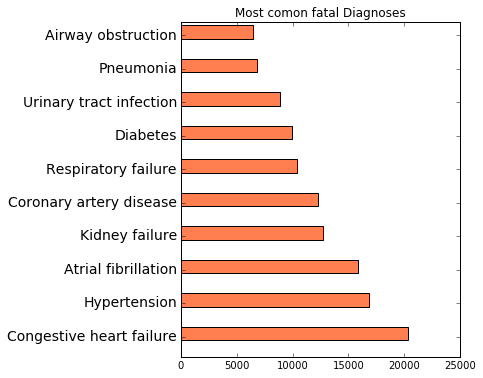

In [27]:
plt.figure(figsize = (5,6))
x = np.arange(10)
wid = 0.4

plt.barh(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission', color='coral')
plt.yticks(x+0.6, cols1, fontsize=14)
#plt.legend()
#plt.tight_layout()  
plt.title("Most comon fatal Diagnoses")
#plt.savefig('fatal_diagnoses',DPI=600);

In [102]:
""" Same as ABOVE ^^^ but horizontal -- not necessary"""
# plt.figure(figsize = (10,5))
# x = np.arange(10)
# wid = 0.4

# plt.bar(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
# plt.xticks(x, cols1, rotation=35, fontsize=14)
# plt.legend()
# plt.tight_layout()  
# plt.savefig('fatal_diagnoses',DPI=600);

' Same as ABOVE ^^^ but horizontal -- not necessary'

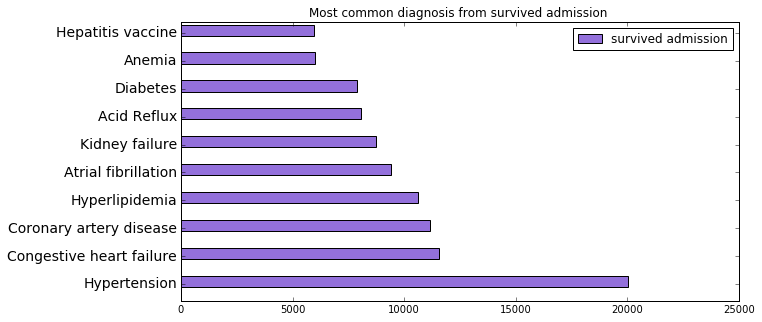

In [28]:
"""
    (when we have tmp_alive)
"""
plt.figure(figsize = (10,5))
x = np.arange(10)
wid = 0.4

plt.barh(0.5+x, tmp_alive.num_alive_flags, wid, color='mediumpurple', label='survived admission')
plt.yticks(x+0.6, cols2, fontsize=14)
plt.legend()
#plt.tight_layout() 
plt.title("Most common diagnosis from survived admission ")
#plt.savefig('survived_diagnosis');

as can be seen from the plots above Congestive Heart failure is both the second most survived and the most fatal diagnosis. The opposite is true for Hypertension.
**So do Hypertension and Congestive Heart failure predict survival or fatality? **

It doesn't seem to be a feature with a lot of predictive power and it may not make much sense to include it in the model. Similarly Diabetes is included in both top-10. A different feature selection model is necessary to find the diagnoses that are much more likely to be predictive of a fatal admission when included as a feature. 

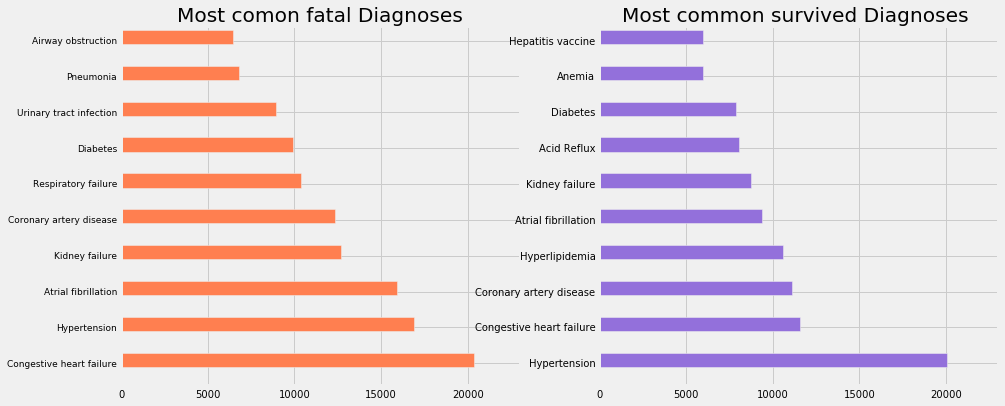

In [73]:
"""combined plot
    cols1 = set in part 3b (most common fatal)
    cols2 = set in part 3c (most common survived)
"""
#plt.figure(figsize = (10,5))
fig, ax = plt.subplots(1,2, figsize = (14,6))
x = np.arange(10)
wid = 0.4
ax[0].yaxis.set_tick_params(labelsize=9)
ax[0].xaxis.set_tick_params(labelsize=10)
ax[1].yaxis.set_tick_params(labelsize=10)
ax[1].xaxis.set_tick_params(labelsize=10)


ax[0].barh(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission', color='coral')
ax[0].set_yticks(x+0.6)
ax[0].set_yticklabels(cols1)#, fontsize=14)
#ax[0].tight_layout()  
ax[0].set_title("Most comon fatal Diagnoses")
ax[0].set_xlim(0,23000)


ax[1].barh(0.5+x, tmp_alive.num_alive_flags, wid,color='mediumpurple'
           ,label='survived admission')
ax[1].set_yticks(x+0.6)
ax[1].set_yticklabels(cols2)#, fontsize=14)
ax[1].yaxis.set_label_position("right")
ax[1].set_xlim(0,23000)
#plt.tight_layout() 
plt.title("Most common survived Diagnoses ")

#plt.savefig('fatal_diagnoses',DPI=600);
#plt.savefig('mostcommon_combined' ,DPI=900,bbox_inches="tight")


#### Compare the most common fatal/alive diagnoses: 

In [74]:
tmp_fatal.long_title.values

array(['Congestive heart failure, unspecified',
       'Unspecified essential hypertension', 'Atrial fibrillation',
       'Acute kidney failure, unspecified',
       'Coronary atherosclerosis of native coronary artery',
       'Acute respiratory failure',
       'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
       'Urinary tract infection, site not specified',
       'Pneumonia, organism unspecified',
       'Chronic airway obstruction, not elsewhere classified'],
      dtype=object)

In [75]:
tmp_alive.long_title.values

array(['Unspecified essential hypertension',
       'Congestive heart failure, unspecified',
       'Coronary atherosclerosis of native coronary artery',
       'Other and unspecified hyperlipidemia', 'Atrial fibrillation',
       'Acute kidney failure, unspecified', 'Esophageal reflux',
       'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
       'Anemia, unspecified',
       'Need for prophylactic vaccination and inoculation against viral hepatitis'],
      dtype=object)

## Part 3c: create a mini-table pre_Bayes

In [185]:
""" 
    tmp_fatal - need a DF of (unique) codes, sorted by NUM most expired flags
"""
tmp_fatal = (merged_MOSTCOMMONicd9.
groupby('icd9_code')
 .first()
 .reset_index().sort_values('num_expire_flags', ascending=False))[:25]

tmp_alive =(merged_MOSTCOMMONalive
.groupby('icd9_code')
.first()
.reset_index().sort_values('num_alive_flags', ascending=False))[:25]

tmp_fatal.drop(['hadm_id_y','icd9_code.1', 'subject_id_y','row_id.1'], axis=1, inplace=True)

In [205]:
"""
    Uses df_model (created in part 4.)
    rerun part 4 if running from scratch 
"""

### Choose only rows with these codes
fatal_codes = tmp_fatal.icd9_code.unique()
alive_codes = tmp_alive.icd9_code.unique()

### use df_expired and df_alive to create
a = df_expired[df_expired.loc[:,'icd9_code'].isin(fatal_codes)]
b = df_alive[df_alive.loc[:,'icd9_code'].isin(alive_codes)]
total = pd.concat([a,b])

pre_bayes  = pd.merge(total, df_model, how='left', on='hadm_id')

In [208]:
### clean up pre-bayes a little
pre_bayes = pre_bayes.drop(['expire_flag_x','subject_id_x', 'icd9_code_y', 'year'], axis=1)
pre_bayes.rename(columns={'icd9_code_x': 'icd9_code' },inplace=True)

In [209]:
pre_bayes[:3]

,hadm_id,subject_id,expire_flag,icd9_code,gender,admission_type,diagnosis,age,d
0,121205,91,1,51881,1,2,FEVER,81.0,1
1,121205,91,1,51881,1,2,FEVER,81.0,1
2,121205,91,1,51881,1,2,FEVER,81.0,1


In [218]:
"""to be merged later w/pre_pivot
"""
pre_tmp = (pre_bayes
 .groupby('hadm_id')['hadm_id','subject_id','expire_flag','gender','admission_type','diagnosis','age']
 .head(1)
  )

In [219]:
""" pre- refers to pre-Bayes"""
pre_pivot = pd.pivot_table(pre_bayes, values='d', index=['hadm_id','subject_id'], columns=['icd9_code'])

In [224]:
### flatten the index, and fill NaN's with 0
pre_pivot.reset_index(col_level=0, inplace = True)
pre_pivot.fillna(0, inplace=True)

In [228]:
"""merge on admissio-id and subject id
"""
merged_pre_bayes = pd.merge(pre_tmp, pre_pivot, how='left', on=['hadm_id','subject_id'])

In [229]:
merged_pre_bayes[:3]


,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,0389,2449,25000,...,5856,5859,5990,99592,V053,V290,V3000,V4581,V5861,V5867
0,121205,91,1,1,2,FEVER,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183686,94,1,0,2,SEPSIS,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140037,94,1,0,2,PNEUMONIA,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
merged_pre_bayes.shape

(54381, 39)

In [232]:
"""
    SAVE TO FILE (for mini modeling)
"""
#merged_pre_bayes.to_csv('pre_bayes_data_model.csv', index=None)

## Part 3d: Create an external test set;
- randomly choose 20000 rows 
- allow for ALL icd9 codes

In [233]:
df_model[:3]

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,year,d
0,121205,91,1,20008,1,2,FEVER,81.0,2095,1
1,121205,91,1,2765,1,2,FEVER,81.0,2095,1
2,121205,91,1,5559,1,2,FEVER,81.0,2095,1


In [249]:
## Randomly choose 10,000 rows from alive and 10,000 from expired
df_a = df_alive.iloc[np.random.randint(0, len(df_alive), 10000)]
df_e = df_expired.iloc[np.random.randint(0, len(df_expired), 10000)]

total = pd.concat([df_a,df_e])
ext_test  = pd.merge(total, df_model, how='left', on=['hadm_id'])

ext_test = ext_test.drop(['expire_flag_x','subject_id_x', 'icd9_code_y', 'year'], axis=1)
ext_test.rename(columns={'icd9_code_x': 'icd9_code' },inplace=True)

"""to be merged later w/pre_pivot
"""
ext_tmp = (ext_test
 .groupby('hadm_id')['hadm_id','subject_id','expire_flag','gender','admission_type','diagnosis','age']
 .head(1)
  )

In [256]:
""" pivot """
ext_pivot = pd.pivot_table(ext_test, values='d', index=['hadm_id','subject_id'], columns=['icd9_code'])

### flatten the index, and fill NaN's with 0
ext_pivot.reset_index(col_level=0, inplace = True)
ext_pivot.fillna(0, inplace=True)

In [257]:
ext_pivot[:3]

icd9_code,hadm_id,subject_id,00845,0088,0091,0311,0340,0380,03810,03811,...,V8537,V854,V8541,V8542,V8543,V8544,V860,V872,V8741,V8801
0,100003,54610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,87977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100016,68591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
""" MERGE """
merged_external_data= pd.merge(ext_tmp, ext_pivot, how='left', on=['hadm_id','subject_id'])

In [259]:
merged_external_data[:3]

,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,00845,0088,0091,...,V8537,V854,V8541,V8542,V8543,V8544,V860,V872,V8741,V8801
0,145978,30575,0,0,2,CO2 NARCOSIS,50.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108945,11861,0,1,2,DIABETIC KETOACIDOSIS;TELEMETRY,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137003,49623,0,1,2,SEPSIS,60.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
""" SAVE """
#merged_external_data.to_csv("external_validate.csv",  index=None)

# Part 4: Naive bayes;  find good features from Diagnoses using Likelihood model


**data tables** : 
These two data tables are the same; they just are for different expire flags: 1 - fatal, 0- survived. They count up ** AND SORT**  by the most fatal/survived cases

                    new_alive, -- long survived 
            most_common_icd9   -- long fatal 


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]


+ ** Ratio_Pd_Ps is the Fatality **
    + the higher this ratio, the more fatal a particular icd9 code is
+ this second fraction I have
+ the baseline/prior is just the ratio of total_death/total_survival

### Some results: not all icd9-codes seem fatal:  

Number of unique icd9 codes for Survival + Fatal admissions:  6422 4823

### Create merged_nbayes:
Contains 

In [17]:
# finish Clean up; don't need hadm_id/subject_id here 
most_common_icd9.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)


In [20]:
### use pre-merged Fatal/Alive Data frames
print( " Number of unique icd9 codes for Survival + Fatal admissions: ", len(new_alive), 
      len(most_common_icd9))
new_alive[:3]

 Number of unique icd9 codes for Survival + Fatal admissions:  6422 4823


,icd9_code,num_alive_flags
1704,4019,20032
1843,4280,11548
1757,41401,11140


In [21]:
most_common_icd9[:2]

,icd9_code,num_expire_flags
1627,4280,20339
1495,4019,16894


1. Number of AND type of 1cd9_code which have NO Fatal admission: 
    + merge, set as N/A for num_expire_flags in most_common_icd9 

In [32]:
# from Part 3 : below 
total_fatal = 22586
total_survival =  36390

In [22]:
# merge left on most_common_icd9, ie. keep all of icd9
merged_nbayes = pd.merge(most_common_icd9, new_alive, how='right', on='icd9_code')

In [24]:
merged_nbayes.sort_values('num_alive_flags')

,icd9_code,num_expire_flags,num_alive_flags
6421,V9103,NaN,1
3885,78262,1.0,1
5637,V716,NaN,1
5638,E8611,NaN,1
5639,E8178,NaN,1
5640,E8587,NaN,1
5641,E856,NaN,1
5636,E8619,NaN,1
5642,E8554,NaN,1
5644,V812,NaN,1


In [34]:
#P_icd9_Death
merged_nbayes['P_icd9_Survival']= merged_nbayes.num_alive_flags/total_survival
#P_icd9_Survival
merged_nbayes['P_icd9_Death']=merged_nbayes.num_expire_flags/total_fatal

/Users/billierolih/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [35]:
merged_nbayes[:3]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death
0,4280,20339.0,11548,0.317340,0.900514
1,4019,16894.0,20032,0.550481,0.747985
2,42731,15895.0,9396,0.258203,0.703755


#### make sure icd9_codes for which there are no fatalities return P_icd9_death = 0
* basically remove NaN

In [36]:
#merged_nbayes.sort_values('num_expire_flags')

merged_nbayes.loc[merged_nbayes.num_expire_flags.isnull()].count()

icd9_code           2161
num_expire_flags       0
num_alive_flags     2161
P_icd9_Survival     2161
P_icd9_Death           0
dtype: int64

In [37]:
merged_nbayes.shape

(6422, 5)

In [87]:
# P(survival | icd9)
# baseline* (0.317340)`

In [ ]:
# P(death | icd9)
baseline*(0.900514)

## part 4a: What is Ratio_Pd_Ps? + Add  Diagnoses Dictionary

**Ratio_Pd_Ps ** -- is the Fatality
The exact question we are answering here: give icd9 = x, what are the odds of Death over Survival? 

dataframes: 
                    + most_Survival
                    + most_Death (or zed) 
            
these just counts the same icd9 codes and sorts by Ratio_Pd_Ps (Fatality Ratio)  

In [38]:
# Calculate Ratio_Pd_Ps: ratio of Death to Survival
baseline = total_fatal/total_survival

#Ratio_Pd_Ps
merged_nbayes['Ratio_Pd_Ps']= baseline*merged_nbayes.P_icd9_Death/merged_nbayes.P_icd9_Survival

In [39]:
baseline

0.62066501786205

In [40]:
merged_nbayes[:3]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps
0,4280,20339.0,11548,0.317340,0.900514,1.761257
1,4019,16894.0,20032,0.550481,0.747985,0.843351
2,42731,15895.0,9396,0.258203,0.703755,1.691677


In [41]:
merged_nbayes

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps
0,4280,20339.0,11548,0.317340,0.900514,1.761257
1,4019,16894.0,20032,0.550481,0.747985,0.843351
2,42731,15895.0,9396,0.258203,0.703755,1.691677
3,5849,12690.0,8721,0.239654,0.561852,1.455108
4,41401,12325.0,11140,0.306128,0.545692,1.106373
5,51881,10397.0,5636,0.154878,0.460329,1.844748
6,25000,9906.0,7883,0.216625,0.438590,1.256628
7,5990,8920.0,5681,0.156114,0.394935,1.570146
8,486,6802.0,3784,0.103985,0.301160,1.797569
9,496,6450.0,3585,0.098516,0.285575,1.799163


In [102]:
# some of the Lowest values (these icd9 Codes suggest that )
merged_nbayes.sort_values('Ratio_Pd_Ps')[:10]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps
3545,V053,2.0,5959,0.163754,0.000089,0.000336
3849,76527,1.0,910,0.025007,0.000044,0.001099
3679,77081,2.0,1089,0.029926,0.000089,0.001837
3691,76518,2.0,955,0.026243,0.000089,0.002094
3681,7706,2.0,765,0.021022,0.000089,0.002614
2198,V3000,12.0,3685,0.101264,0.000531,0.003256
3139,7793,4.0,1133,0.031135,0.000177,0.003530
3304,7746,3.0,797,0.021902,0.000133,0.003764
3693,76517,2.0,488,0.013410,0.000089,0.004098
1606,V290,26.0,5618,0.154383,0.001151,0.004628


In [103]:
#pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

merged_FIN = (pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

In [203]:
#merged_FIN[:5]


In [105]:
# 20 most common icd9 numbers for observed POSITIVE Survival Odds
most_Survival = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps'))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps','short_title','long_title']][:15]

In [106]:
most_Survival

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,short_title,long_title
5997,V053,2.0,5959,0.000336,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...
3847,76527,1.0,910,0.001099,33-34 comp wks gestation,33-34 completed weeks of gestation
3881,77081,2.0,1089,0.001837,Primary apnea of newborn,Primary apnea of newborn
3839,76518,2.0,955,0.002094,Preterm NEC 2000-2499g,"Other preterm infants, 2,000-2,499 grams"
3878,7706,2.0,765,0.002614,NB transitory tachypnea,Transitory tachypnea of newborn
6177,V3000,12.0,3685,0.003256,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w..."
3959,7793,4.0,1133,0.003530,NaN,NaN
3920,7746,3.0,797,0.003764,Fetal/neonatal jaund NOS,Unspecified fetal and neonatal jaundice
3838,76517,2.0,488,0.004098,Preterm NEC 1750-1999g,"Other preterm infants, 1,750-1,999 grams"
6172,V290,26.0,5618,0.004628,NB obsrv suspct infect,Observation for suspected infectious condition


In [109]:
most_Death = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps', ascending=False))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps',
                                                             'short_title','long_title']][:50]

In [111]:
zed = most_Death[['icd9_code','num_expire_flags', 'num_alive_flags', 'Ratio_Pd_Ps', 'long_title']]

#zed.loc[ze866,:]

In [112]:
zed.loc[zed['icd9_code']=='1972',:]
zed.loc[zed['icd9_code']=='1984',:].long_title.values

zed.loc[zed['icd9_code']=='99685',:]
zed.loc[zed['icd9_code']=='51181',:]# 485
zed.loc[zed['icd9_code']=='07041',:]

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,long_title
143,07041,31.0,2,15.5,Acute hepatitis C with hepatic coma


zed

In [ ]:
zed.loc[485,:]

In [ ]:
## Number of NAN flags in expire_flags
merged_nbayes[merged_nbayes.num_expire_flags.isnull()].count()

In [ ]:
# there are no icd9_codes that are automatic surivval!!
merged_nbayes[merged_nbayes.num_alive_flags.isnull()].count()

#  Part 5: DataFrame with icd9 - as features
start with Admission-Patient data called "data
uses 
    + most_Death - (47,6) the top 47  icd9 codes
    + icd9_features - array of all the icd9 codes

** Contains Pivot table **

In [113]:
# drop NAN values
most_Death = most_Death.dropna()

In [114]:
#list(most_Death.icd9_codae)
most_Death[:3]

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,short_title,long_title
866,27953,53.0,1,53.0,Ac on chrn grft-vs-host,Acute on chronic graft-versus-host disease
307,1560,43.0,1,43.0,Malig neo gallbladder,Malignant neoplasm of gallbladder
1494,36400,34.0,1,34.0,Acute iridocyclitis NOS,"Acute and subacute iridocyclitis, unspecified"


In [116]:
icd9_features = most_Death.icd9_code.values

In [117]:
icd9_features

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239',
       '85225', 'V1062', '20030', '1972', 'V4578', '46611', '99688',
       '1971', '07031', '1530', '1965', '1481', '78939', '20510', '07041',
       '72290', '3581', '73004', '1984', '485', '3693', '85205', '1910',
       '4449', '9878', '5581', '48801', 'V143', '2468', 'V568', '37900',
       '99685', '6829', '25023', 'E9278', '36001', '58281', '1519',
       '29389', '51181'], dtype=object)

In [121]:
"""#########  RUN ONCE 
Cleaning data """

# df_model = data.drop( ['hospital_expire_flag', 'has_ioevents_data', 'has_chartevents_data', u'edregtime',
#            u'edouttime' ], axis = 1)
# df_model = df_model.drop( [ u'insurance', u'language', u'religion', u'marital_status', u'ethnicity' ], axis = 1)
# df_model = df_model.drop( [u'admission_location', u'discharge_location',u'admittime', u'dischtime', u'deathtime',u'row_id',], axis = 1)

# df_model = df_model.drop( [ u'dob', u'dod', u'subject_id.1' ], axis = 1)

df_model.shape

(58976, 8)

In [122]:
df_model[:3]

,subject_id,gender,expire_flag,hadm_id,admission_type,diagnosis,age,year
0,30,0,0,104557,1,UNSTABLE ANGINA\CATH,90.0,1872
1,8402,0,0,177676,1,CHEST PAIN\CATH,62.0,2105
2,146,0,1,190707,1,CONGESTIVE HEART FAILURE\CATH,85.0,2034


##### ADD ICD-9 to df_model 
+ merge df_expired onto df_model (for expire_flag=1) 
+ merge df_alive

In [123]:
##### Concatinate fatal + alive icd9-code Data Frames
print (len(df_expired))
print ( len(df_alive))

frames = [df_expired, df_alive]
result = pd.concat(frames)

### Retain all rows in result : left merge 
    ## there shouldn't be any hadm_id's in df_model NOT in result
    ## if there are, not interesting, because we need icd9_codes
    
df_model  = pd.merge(result, df_model, how='left', on='hadm_id')
df_model = df_model.drop(['expire_flag_y','subject_id_y'], axis=1)

719641
655338


In [124]:
df_model.head()

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,year
0,121205,91,1,20008,1,2,FEVER,81.0,2095
1,121205,91,1,2765,1,2,FEVER,81.0,2095
2,121205,91,1,5559,1,2,FEVER,81.0,2095
3,121205,91,1,99812,1,2,FEVER,81.0,2095
4,121205,91,1,51881,1,2,FEVER,81.0,2095


In [179]:
df_model.shape

(1374979, 10)

In [125]:
icd9_features

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239',
       '85225', 'V1062', '20030', '1972', 'V4578', '46611', '99688',
       '1971', '07031', '1530', '1965', '1481', '78939', '20510', '07041',
       '72290', '3581', '73004', '1984', '485', '3693', '85205', '1910',
       '4449', '9878', '5581', '48801', 'V143', '2468', 'V568', '37900',
       '99685', '6829', '25023', 'E9278', '36001', '58281', '1519',
       '29389', '51181'], dtype=object)

In [145]:
keep = icd9_features


In [ ]:
############ add columns 
# for var in icd9_features:
#     df_model[var] = 0

In [127]:
""" test a few individaul  admissions IDs """
df_model[df_model.hadm_id==100018]

df_model[df_model.hadm_id==121205]

In [129]:
"""
    FOR THE PIVOT
    create a column of values 1 
"""
df_model['d']=1
df_model

##### df_tmp
** df_model WITHOUT icd9 **
group_by hospital stay return the first value
- hospital stay
- subject 
- expire ?
- gender 
- diagnosis
- age

In [131]:
df_tmp = (df_model.
 groupby('hadm_id')['hadm_id','subject_id_x','expire_flag_x','gender','admission_type','diagnosis','age']
 .head(1)
  )

In [133]:
df_tmp[:3]

,hadm_id,subject_id_x,expire_flag_x,gender,admission_type,diagnosis,age
0,121205,91,1,1,2,FEVER,81.0
9,183686,94,1,0,2,SEPSIS,74.0
25,140037,94,1,0,2,PNEUMONIA,74.0


In [159]:
#keep = keep +
#[np.append(keep, a) for a in df_tmp.columns.values]
keep = list(df_tmp.columns.values) + list(keep)

In [136]:
df_model[:2]

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,year,d
0,121205,91,1,20008,1,2,FEVER,81.0,2095,1
1,121205,91,1,2765,1,2,FEVER,81.0,2095,1


#### Part 5a: Pivot table 
- pivot on icd9_codes
- pass a value of = 1


In [137]:
tmp = pd.pivot_table(df_model, values='d', index=['hadm_id','subject_id_x'], columns=['icd9_code'])

In [138]:
tmp.columns

Index([u'0030', u'0031', u'0038', u'0039', u'0041', u'0048', u'0049', u'0051',
       u'00581', u'0059',
       ...
       u'V8801', u'V8811', u'V8812', u'V8821', u'V9010', u'V902', u'V9039',
       u'V9081', u'V9089', u'V9103'],
      dtype='object', name=u'icd9_code', length=6984)

In [139]:
tmp.columns.name = ''

In [140]:
tmp.reset_index(col_level=0, inplace = True)

In [143]:
tmp.head()

,hadm_id,subject_id_x,0030,0031,0038,0039,0041,0048,0049,0051,...,V8801,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103
0,100001,58526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,54610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,9895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,23018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
### We made this into a LIST not an array anymore
keep

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239',
       '85225', 'V1062', '20030', '1972', 'V4578', '46611', '99688',
       '1971', '07031', '1530', '1965', '1481', '78939', '20510', '07041',
       '72290', '3581', '73004', '1984', '485', '3693', '85205', '1910',
       '4449', '9878', '5581', '48801', 'V143', '2468', 'V568', '37900',
       '99685', '6829', '25023', 'E9278', '36001', '58281', '1519',
       '29389', '51181'], dtype=object)

In [162]:
keep[0:2]

['hadm_id', 'subject_id_x']

In [167]:
new_keep = keep[0:2] + keep[8:]
#keep[0:2].union(keep[8:]keep[0:2])

In [169]:
"""
list of values to be kept : admission id, subject id + 50 CODES
"""
new_keep[:4]

['hadm_id', 'subject_id_x', '1560', '36400']

In [170]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58973 entries, 0 to 58972
Columns: 6986 entries, hadm_id to V9103
dtypes: float64(6984), int64(2)
memory usage: 3.1 GB


#### KEY: keep only 50 icd9 codes of the pivoted table

In [171]:
"""
    THIS IS KEY: KEEP ONLY 50 ICD9 CODES
"""
tmp = tmp.loc[:,new_keep]

In [172]:
tmp.fillna(0, inplace=True)

In [175]:
# testing tmp
tmp[tmp['V1062']==1]

,hadm_id,subject_id_x,1560,36400,36019,3643,1715,37239,85225,V1062,...,37900,99685,6829,25023,E9278,36001,58281,1519,29389,51181
425,100711,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1447,102435,23849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2059,103434,25258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2425,104041,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3767,106349,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3843,106481,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5249,108881,6196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14128,123892,27472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15452,126167,25258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17959,130371,27472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge on hospital stay 

How to create a pivot table ready for modeling, ie. how to encode Diagnosis Codes 
** Logistic regression takes in only numeric values, so diagnosis codes have to be encoded in [0,1] format **


1. **df_model** should be a DF containing: 
    1. 	hadm_id	subject_id_x	expire_flag_x	icd9_code	gender	admission_type	diagnosis	age
    1. ** every Row of df_model ** contains a unique icd9-code, per hospital stay
    1. that's why it has so many rows
    1. ** num Rows** = hospital-stays x icd9-code 
1. create a column of =1 in **df_model**
    1. for the merge, to pass as values
1. pivot **tmp**
        1. tmp = pd.pivot_table(df_model, values='d', index=['hadm_id','subject_id_x'], columns=['icd9_code'])
1. ** reset index level ** at tmp
        1. tmp.reset_index(col_level=0, inplace = True)
1. Merge **df_tmp** (DF with gender, admission_type, diagnosis, age, expire_flag, AND hamd_id, subject_id,) and ** tmp ** (pivot DF with hamd_id, subject_id, AND encoded icd9 codes) 
    1. on hamd_id (HOSPITAL stay)
    1. how = left
1. drop the extra columns 
        1. .drop('subject_id_x_y', axis=1, inplace=True)
    



In [178]:
df_tmp[:3]

,hadm_id,subject_id_x,expire_flag_x,gender,admission_type,diagnosis,age
0,121205,91,1,1,2,FEVER,81.0
9,183686,94,1,0,2,SEPSIS,74.0
25,140037,94,1,0,2,PNEUMONIA,74.0


In [ ]:
print(len(df_tmp))
print(len(tmp))
#(pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

In [ ]:
merged_FINAL = pd.merge(df_tmp, tmp, how='left', on='hadm_id')

In [ ]:
merged_FINAL.drop('subject_id_x_y', axis=1, inplace=True) 

In [ ]:
merged_FINAL.rename(columns={'subject_id_x_x': 'subject_id','expire_flag_x':'expire_flag' },inplace=True)

In [ ]:
merged_FINAL[:3]

# FINAL DATAFRAME TO BE SAVED

In [ ]:
"""
    TO-CSV
    DO NOT RUN AGAIN 
"""

##merged_FINAL.to_csv('data_model1.csv', index=None)

In [ ]:
tmp.info()

In [ ]:
tmp

In [ ]:
###### NOT USED 
# mydict={}
# #tmp = grouped['icd9_code'].apply(lambda x: [x] )
# #{k: g["value"].tolist() for k,g in ptest.groupby("id")}

# mydict = {k: g["icd9_code"].tolist() for k,g in df_model.groupby('hadm_id')}

In [ ]:
###### NOT USED 
# #first2pairs = {k: mydict[k] for k in sorted(mydict.keys())[:1]}
# ### Key = hadm_id
#     # vals: icd9_code
# first2pairs = {k: mydict[k] for k in mydict.keys()[:1]}
# first2pairs

In [ ]:
#################### remove 'icd9_code' column and group by 	hadm_id get smaller dataFrame (back to 59,000)

In [ ]:
# df_model = (df_model.groupby('hadm_id')
#  .first()
#  .reset_index())

#### NOW YOU CAN DROP THE  icd9_code

In [ ]:
# #### NOW YOU CAN DROP THE 
# df_model = df_model.drop(['icd9_code'], axis=1)

In [ ]:
df_model.head(4)

In [ ]:
#columns to keep
keep = df_model.columns
keep 

In [ ]:
# # for a in mydict[100001]:
# #     print (a)
# len(mydict[100018])

In [ ]:
###### NOT USED 
# #key is hadm_id
# # traverse df_model.hadm_id use key-value

# for ix in range(len(df_model)):
   
#     key= df_model.loc[ix, 'hadm_id']
    
#     # traverse the array in mydict[key]
#     for a in mydict[key]: 
#         if a in icd9_features:
#             print(key, a)
#             #df_model.loc[ix,a] = 1  
    

In [ ]:
df_model.info()

In [ ]:
#result.loc[(result.hadm_id ==111199 )& (result.icd9_code=='485')]['expire_flag']

In [ ]:
# 4th 
procedures.loc[procedures['icd9_code']== 	5849]

In [ ]:
pd.merge(most_common_icd9_smaller, procedures, how='left',on='icd9_code');

# 3. Combination of Patients and Admissions table
+ admissions have a: unique HADM_ID
+ 
goals
+ get the age of the subject at admit-time

## First: get total number of Deaths and Survivals

In [ ]:
## How many subject_ids? (PATIENTS total) = 46520
print ( "total number unique patients:  ", len(data.subject_id.unique()) )
print ( "total number unique admissions:  ", len(data.hadm_id.unique()) ), '\n'


######################## How many fatal visits? ####################################
print ( "total fatal hospital visits: " , data[data.expire_flag==1]['expire_flag'].count())
print ( "total surviving hospital visits: " , data[data.expire_flag==0]['expire_flag'].count()), '\n'

### How many of each Admission type fatal

In [ ]:
data[data.gender.isnull()]['gender'].count()

In [ ]:
data.admission_type.value_counts()

In [ ]:
data[:3].expire_flag

In [ ]:
admit_survival = (data.groupby(['admission_type','expire_flag'])
['gender'].count().rename('Count')
.reset_index())

In [ ]:
admit_survival

Emergency and urgent have the highest percentages of fatalities, followed by elective surgery
Newborns are surprisingly resilient


In [ ]:

print (" elective ", 2186./(5520+2186)*100)
print (" emergency ", 19650./(19650+22421)*100)
print (" newborn ", 65./(65+7798)*100)
print (" urgent ", 685./(685+651)*100)

Time related: "u'edregtime', u'edouttime'" what is this shit?

Time that the patient was registered and discharged from the emergency department.

##### pick the right admission time
1. One way of doing it: Count from **when they were admitted to the emergency department ** ('edregtime', u'edouttime')
1. OR  **when they were admitted to the hospital **  u'admittime',
    - choose 2. right now, and come back to later if relevant

In [ ]:
data.columns


In [ ]:
df_smaller=data.loc[:, [ 'hadm_id','dob','admittime' ]]
                    #['subject_id', u'gender', u'dob', u'dod', u'expire_flag']]

In [ ]:
df_smaller[:3]

In [ ]:
isinstance(df_smaller.dob,pd.DatetimeIndex)

In [ ]:
isinstance(df_smaller.dob,pd.Timestamp)

#it's not a timestamp, convert it to Timestamp

In [ ]:
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(df_smaller.admittime) - pd.to_datetime(df_smaller.dob )
              ).astype('<m8[Y]')

In [ ]:
data['age'][:3]

In [ ]:
data.age.describe()

DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. 
** change all ages <0 to  90 **

In [ ]:
# number o
data.age.where(data['age']< 0).count()

In [ ]:
#### SET ALL GREATER THAN 90 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

In [ ]:
data.age[:3]

In [ ]:
#data['age'].where(data['age'] > 80 and data['age']< 90)

## use .query method, it's nice
print (" number of people who have a DOD, of age b/w 80, and 90 "
       , data.query(' 80 < age <90 ' )['dod'].count())
print (" number of people who have a DOD, of age b/w 80, and 90 ", 
    data.query(' 80 < age <90 ' )['subject_id'].count() )

In [ ]:
pd.to_datetime()

## Other ideas 
+ convert all times to datetime
+ can certain time of day classify death? 


In [ ]:
data.admission_location.unique()

In [ ]:
data.columns

In [ ]:
df_fit = data.loc[:, ['subject_id','gender','age','admission_type', 'expire_flag']]

In [ ]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df_fit.admission_type.unique())

df_fit.admission_type.replace(cols, nums, inplace=True)

In [ ]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df_fit.gender.replace(gen, n_g, inplace=True)

In [ ]:
df_fit[:4]


# First Logistic Model: Gender, Age, Admission type

In [ ]:
X = df_fit.loc[:,['gender', 'age', 'admission_type']]

y = df_fit.loc[:, 'expire_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

In [ ]:

##y_pred_1 = lr_model.predict_proba(X_test)

In [ ]:
 

for col in X_train.columns:
    print (col)
    X_tr = X_train.loc[:, col].values.reshape(-1,1)
    X_te = X_test.loc[:,col].values.reshape(-1,1)
    lr_model = LogisticRegression()
    lr_model.fit(X_tr, y_train)
    y_prob_pred = lr_model.predict_proba(X_te)[:,1]
    print( "log-loss",log_loss(y_test, y_prob_pred)) 

In [ ]:
## this is for .predict() method
# print (" accuracy" , accuracy_score(y_test, y_pred_1, normalize=True))
# print ("precision",precision_score(y_test, y_pred_1))
# print ("recall",recall_score(y_test, y_pred_1))

## Look at Admission Type

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,'admission_type'],y,test_size=0.3, random_state=4444 )

In [ ]:
lr_model_a = LogisticRegression()
lr_model_a.fit(X_train, y_train)
y_pred_a = lr_model_a.predict(X_test)

In [ ]:
X.loc[:,'admission_type']

In [ ]:
print (" accuracy" , accuracy_score(y_test, y_pred_a, normalize=True))
print ("precision",precision_score(y_test, y_pred_a))
print ("recall",recall_score(y_test, y_pred_a))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['gender']],y,test_size=0.3, random_state=4444 )

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
lr_modelGender = LogisticRegression()
lr_modelGender.fit(X_train, y_train)
y_pred_Gender = lr_modelGender.predict(X_test)

In [ ]:
print (" accuracy" , accuracy_score(y_test,y_pred_Gender , normalize=True))
print ("precision",precision_score(y_test, y_pred_Gender))
print ("recall",recall_score(y_test, y_pred_Gender))

Gender itself is a terrible predictor 

### IF you wanna deal with ethnicity

In [ ]:
eth = list(data.ethnicity.unique())

In [ ]:
eth.sort()

In [ ]:
print (len(eth))
eth


In [ ]:
print (data[data.ethnicity=='UNKNOWN/NOT SPECIFIED']['subject_id'].count())
print (data[data.ethnicity=='OTHER']['subject_id'].count())
print (data[data.ethnicity=='PATIENT DECLINED TO ANSWER']['subject_id'].count())


In [ ]:
''' Ethnicty Dictionary
    White (any) +Portugese = 0
    Black (any) = 1
    Hispanic/South American (any) + Carribbean = 2
    Asian (any) + hawaiian (pac islander) = 3
    Native American  = 4
    Multi Race = 5 
    
'''

In [ ]:
data.columns

In [ ]:
df_fit = data.loc[:, ['subject_id','gender','age', 'ethnicity', 'expire_flag']]

In [ ]:
print(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())

In [ ]:
(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())

In [ ]:
(df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
print (len((df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
)) # Hispanic
print (len((df_fit[df_fit.ethnicity.str.contains('BLACK')]['ethnicity'].unique())
)) # Black

In [ ]:
print ((df_fit[df_fit.ethnicity.str.contains('INDIAN')]['ethnicity'].unique() ))

In [ ]:
print ((df_fit[df_fit.ethnicity.str.contains('AMERICAN INDIAN')]['ethnicity'].unique() ))

In [ ]:
def convert_eth():
    